# Fluxnet vs PV data

Loads Fluxnet data for summarising and comparison to PV fields

In [1]:
import numpy as np
import pandas as pd
import glob
import re

### Note:

The following data is not provided here, as it is available on the Fluxnet & Euroflux networks. Please request it there from the site maintainers.

In [2]:
project_path = './'

data_path = project_path + '../data/fluxnet/'
out_path  = project_path + '../graphs/'

# FLUXNET
# Australia
fluxAU_dap = data_path + 'FLX_AU-DaP_FLUXNET2015_SUBSET_2007-2013_2-4/FLX_AU-DaP_FLUXNET2015_SUBSET_HH_2007-2013_2-4.csv'
fluxAU_das = data_path + 'FLX_AU-DaS_FLUXNET2015_SUBSET_2008-2014_2-4/FLX_AU-DaS_FLUXNET2015_SUBSET_HH_2008-2014_2-4.csv'
fluxAU_how = data_path + 'FLX_AU-How_FLUXNET2015_SUBSET_2001-2014_1-4/FLX_AU-How_FLUXNET2015_SUBSET_HH_2001-2014_1-4.csv'
# Panama
fluxPA_spn = data_path + 'FLX_PA-SPn_FLUXNET2015_SUBSET_2007-2009_1-4/FLX_PA-SPn_FLUXNET2015_SUBSET_HH_2007-2009_1-4.csv'
fluxPA_sps = data_path + 'FLX_PA-SPs_FLUXNET2015_SUBSET_2007-2009_1-4/FLX_PA-SPs_FLUXNET2015_SUBSET_HH_2007-2009_1-4.csv'
# Germany
fluxDE_hai = data_path + 'FLX_DE-Hai_FLUXNET2015_SUBSET_2000-2012_1-4/FLX_DE-Hai_FLUXNET2015_SUBSET_HH_2000-2012_1-4.csv'
fluxDE_lnf = data_path + 'FLX_DE-Lnf_FLUXNET2015_SUBSET_2002-2012_1-4/FLX_DE-Lnf_FLUXNET2015_SUBSET_HH_2002-2012_1-4.csv'

# EUROFLUX
# Germany
fluxDE_gri = data_path + 'DE-Gri/'
fluxDE_me2 = data_path + 'DE-Me2/'
fluxDE_meh = data_path + 'DE-Meh/'
fluxDE_tha = data_path + 'DE-Tha/'
fluxDE_hzd = data_path + 'DE-Hzd/'

# Albedo constants from literature
albedo_amazon_forest = 0.13
albedo_amazon_grassland = 0.18

### Functions required for loading & averaging

In [3]:
def load_fluxnet(fn, IGBP, silent=False):
    file = re.split(r'/', fn.strip())[-1]
    if(not silent): print('    ' + file)
    # Load raw data
    df = pd.read_csv(fn, na_values = -9999) # -9999 is NA
    # Timestamps
    df['timestamp'] = pd.to_datetime(df["TIMESTAMP_START"], format = '%Y%m%d%H%M')
    df['timestamp'] = df['timestamp'] + pd.Timedelta(minutes=15)
    # drop unnecessary timestamp columns
    df.drop(columns=['TIMESTAMP_START', 'TIMESTAMP_END'], inplace=True)
    # Determine site from path
    site    = re.split(r'_', fn.strip())[-6]
    country = re.split(r'-', site.strip())[-2]
    # Add other metadata columns
    df['country'] = country
    df['site'] = site
    df['IGBP'] = IGBP
    # Move timestamp to front
    col = df.pop('IGBP')
    df.insert(0, col.name, col)
    col = df.pop('site')
    df.insert(0, col.name, col)
    col = df.pop('country')
    df.insert(0, col.name, col)
    col = df.pop('timestamp')
    df.insert(0, col.name, col)
    return(df)

def read_folder(path, pattern, silent=False):
    files = glob.glob(path + pattern + '*')
    site = re.split(r'/', path.strip())[-2]
    if(not silent): print('    ' + site)
    # Read into list of dfs
    df_list = [ ]
    for f_i, f in enumerate(files):
        percent = f_i * 100 / len(files)
        fn = re.split(r'/', f.strip())[-1]
        if(not silent): print('\t', str(round(percent)) + '%', '\t', fn)
        # Read the data
        df_list.append(pd.read_csv(f, na_values = -9999))
    out_df = pd.concat(df_list)
    return(out_df)

def load_euroflux(path, IGBP, silent=False):
    df = read_folder(path, 'EFDC', silent=silent)
    df['timestamp'] = pd.to_datetime(df["TIMESTAMP_START"], format = '%Y%m%d%H%M')
    df['timestamp'] = df['timestamp'] + pd.Timedelta(minutes=15)
    # drop unnecessary timestamp columns
    df.drop(columns=['TIMESTAMP_START', 'TIMESTAMP_END', 'DTime'], inplace=True)
    # Determine site from path
    site    = re.split(r'/', path.strip())[-2]
    country = re.split(r'-', site.strip())[-2]
    # Add other metadata columns
    df['country'] = country
    df['site'] = site
    df['IGBP'] = IGBP
    # Move timestamp to front
    col = df.pop('IGBP')
    df.insert(0, col.name, col)
    col = df.pop('site')
    df.insert(0, col.name, col)
    col = df.pop('country')
    df.insert(0, col.name, col)
    col = df.pop('timestamp')
    df.insert(0, col.name, col)
    return(df)

def weighted_average(df, values, weights):
    weighted_avg = np.average(df[values], weights=df[weights])
    return(weighted_avg)

# Deals with problems with NAs
def weighted_average2(df, values, weights):
    weighted_avg = np.sum(df[weights] * df[values]) / np.sum(df[weights])
    # Remove values that are 0 from the weighted average because they are a result of summing NAs
    weighted_avg = float(np.where(weighted_avg == 0, np.nan, weighted_avg))
    return(weighted_avg)

## Run the code

- Loads Fluxnet & Euroflux data
- Merge into common dataframe
- Apply outgoing short- ($SW_{out}$) and longwave radiation ($LW_{out}$) corrections where necessary
- Calculate albedo (daily, annually)
- Create multi-year summaries

In [27]:
print('Loading Fluxnet data...')
# Australia
au_dap = load_fluxnet(fluxAU_dap, 'GRA') # Grassland
au_das = load_fluxnet(fluxAU_das, 'SAV') # Savannah
au_how = load_fluxnet(fluxAU_how, 'WSA') # Woody savannah
# Panama 
pa_spn = load_fluxnet(fluxPA_spn, 'DBF') # Evergreen forest
pa_sps = load_fluxnet(fluxPA_sps, 'GRA') # Grassland
# Germany
de_hai = load_fluxnet(fluxDE_hai, 'DBF') # Deciduous forest
de_lnf = load_fluxnet(fluxDE_lnf, 'DBF') # Deciduous forest

print('')
print('Loading Euroflux data...')
de_gri = load_euroflux(fluxDE_gri, 'GRA') # Grassland
de_tha = load_euroflux(fluxDE_tha, 'ENF') # Conifer forest
#de_hzd = load_euroflux(fluxDE_hzd, 'DBF') # Deciduous forest (HOPEFULLY GET THE DATA STILL)
de_me2 = load_euroflux(fluxDE_me2, 'GRA') # Grassland
#de_meh = load_euroflux(fluxDE_meh, 'MF')  # Mixed forest -> Note: This is more similar to the grassland it is next to

print('')
print('Concatenating data...')
# Concatenate all locations
fluxnet  = pd.concat([au_dap, au_das, au_how, de_hai, de_lnf, pa_spn, pa_sps], axis=0, sort=False)
euroflux = pd.concat([de_gri, de_tha, de_me2, ], axis=0, sort=False)

# Select relevant columns
fluxnet  = fluxnet[['timestamp', 'country', 'site', 'IGBP', 'SW_IN_F', 'LW_IN_F','SW_OUT','LW_OUT','NETRAD', 'NEE_VUT_REF']].copy()
euroflux = euroflux[['timestamp', 'country', 'site', 'IGBP', 'SW_IN', 'LW_IN','SW_OUT','LW_OUT']].copy()

# Rename columns in fluxnet to fit euroflux column names
fluxnet.rename(columns={'SW_IN_F': 'SW_IN', 'LW_IN_F': 'LW_IN', 'NEE_VUT_REF': 'NEE'}, inplace=True)

print('Creating final df...')
# Create entire dataset
df = pd.concat([fluxnet, euroflux], axis=0, sort=False)

print('')
print('Done...')

Loading Fluxnet data...
    FLX_AU-DaP_FLUXNET2015_SUBSET_HH_2007-2013_2-4.csv
    FLX_AU-DaS_FLUXNET2015_SUBSET_HH_2008-2014_2-4.csv
    FLX_AU-How_FLUXNET2015_SUBSET_HH_2001-2014_1-4.csv
    FLX_PA-SPn_FLUXNET2015_SUBSET_HH_2007-2009_1-4.csv
    FLX_PA-SPs_FLUXNET2015_SUBSET_HH_2007-2009_1-4.csv
    FLX_DE-Hai_FLUXNET2015_SUBSET_HH_2000-2012_1-4.csv
    FLX_DE-Lnf_FLUXNET2015_SUBSET_HH_2002-2012_1-4.csv

Loading Euroflux data...
    DE-Gri
	 0% 	 DE-Gri\EFDC_L2_Flx_DEGri_2015_v07_30m.txt
	 17% 	 DE-Gri\EFDC_L2_Flx_DEGri_2016_v07_30m.txt
	 33% 	 DE-Gri\EFDC_L2_Flx_DEGri_2017_v010_30m.txt
	 50% 	 DE-Gri\EFDC_L2_Flx_DEGri_2018_v011_30m.txt
	 67% 	 DE-Gri\EFDC_L2_Flx_DEGri_2019_v09_30m.txt
	 83% 	 DE-Gri\EFDC_L2_Flx_DEGri_2020_v011_30m.txt
    DE-Tha
	 0% 	 DE-Tha\EFDC_L2_Flx_DETha_2015_v07_30m.txt
	 25% 	 DE-Tha\EFDC_L2_Flx_DETha_2016_v07_30m.txt
	 50% 	 DE-Tha\EFDC_L2_Flx_DETha_2017_v06_30m.txt
	 75% 	 DE-Tha\EFDC_L2_Flx_DETha_2018_v05_30m.txt
    DE-Me2
	 0% 	 DE-Me2\EFDC_L2_Flx_DEMe2

In [28]:
print('Preparing data...')
df['day']  = df['timestamp'].dt.strftime('%Y%m%d')
df['year'] = df['timestamp'].dt.strftime('%Y')

Preparing data...


In [29]:
print('Calculate SW_OUT and LW_OUT for Panama...')
# Calculate SW_OUT for Panama from albedo and SW_IN
df.loc[df['site'] == 'PA-SPn', 'SW_OUT'] = df.loc[df['site'] == 'PA-SPn', 'SW_IN'] * albedo_amazon_forest
df.loc[df['site'] == 'PA-SPs', 'SW_OUT'] = df.loc[df['site'] == 'PA-SPs', 'SW_IN'] * albedo_amazon_grassland
# Calculate LW_OUT for Panama from net radiation and other parameters
df.loc[df['site'].isin(['PA-SPn', 'PA-SPs']), 'LW_OUT'] = df.loc[df['site'].isin(['PA-SPn', 'PA-SPs']), 'SW_IN'] \
                                                        - df.loc[df['site'].isin(['PA-SPn', 'PA-SPs']), 'SW_OUT'] \
                                                        + df.loc[df['site'].isin(['PA-SPn', 'PA-SPs']), 'LW_IN'] \
                                                        - df.loc[df['site'].isin(['PA-SPn', 'PA-SPs']), 'NETRAD']

# At Australian sites, sometimes there is no SW_OUT but there is the rest
df.loc[df['site'].isin(['AU-DaP', 'AU-DaS']) & df['SW_OUT'].isna(), 'SW_OUT'] = df.loc[df['site'].isin(['AU-DaP', 'AU-DaS']) & df['SW_OUT'].isna(), 'SW_IN'] \
                                                        + df.loc[df['site'].isin(['AU-DaP', 'AU-DaS']) & df['SW_OUT'].isna(), 'LW_IN'] \
                                                        - df.loc[df['site'].isin(['AU-DaP', 'AU-DaS']) & df['SW_OUT'].isna(), 'LW_OUT'] \
                                                        - df.loc[df['site'].isin(['AU-DaP', 'AU-DaS']) & df['SW_OUT'].isna(), 'NETRAD']

Calculate SW_OUT and LW_OUT for Panama...


In [30]:
print('Calculate mean albedo:')
# Calculate albedo:
# - Do daily sum
print('    - Daily sums')
daily_albedo = df.groupby(['country','site','IGBP','day']).sum(min_count=20).reset_index()
# - Calculate albedo
print('    - Albedo')
daily_albedo['albedo'] = daily_albedo['SW_OUT']/daily_albedo['SW_IN']
# - Remove bad data
daily_albedo.loc[daily_albedo['albedo'] >= 1, 'albedo'] = np.nan
daily_albedo.loc[daily_albedo['albedo'] == 0, 'albedo'] = np.nan
# - Do yearly weighted average by SW_IN
print('    - Yearly weighted mean')
daily_albedo['timestamp'] = pd.to_datetime(daily_albedo['day'], format = '%Y%m%d')
daily_albedo['year'] = daily_albedo['timestamp'].dt.strftime('%Y')
yearly_albedo = daily_albedo.groupby(['country','site','IGBP','year']).apply(weighted_average2, 'albedo', 'SW_IN')
yearly_albedo = pd.DataFrame(yearly_albedo)
yearly_albedo = yearly_albedo.rename(columns={ yearly_albedo.columns[0]: 'albedo' }).reset_index()
yearly_albedo['timestamp'] = pd.to_datetime(yearly_albedo['year'], format = '%Y')
yearly_albedo['year'] = yearly_albedo['year'].astype(int)
yearly_albedo.drop(columns=['timestamp'], inplace=True)
# Remove strange values
yearly_albedo.loc[(yearly_albedo['site'] == 'AU-DaP') & (yearly_albedo['year'].isin([2007,2011,2012])), 'albedo'] = np.nan
print('Done...')

Calculate mean albedo:
    - Daily sums
    - Albedo
    - Yearly weighted mean
Done...


In [31]:
print('Calculate other parameters:')
# Other variables
temp = df.copy()

# Remove years with too many missing values
temp.loc[(temp['site'] == 'PA-SPs') & (temp['year'] == '2007'), 'LW_OUT'] = np.nan
temp.loc[(temp['site'] == 'PA-SPn') & (temp['year'] == '2007'), 'LW_OUT'] = np.nan
temp.loc[(temp['site'] == 'AU-DaP') & (temp['year'] == '2007'), 'LW_OUT'] = np.nan
temp.loc[(temp['site'] == 'AU-DaP') & (temp['year'] == '2013'), 'LW_OUT'] = np.nan
temp.loc[(temp['site'] == 'AU-DaS') & (temp['year'] == '2008'), 'LW_OUT'] = np.nan
temp.loc[(temp['site'] == 'AU-How') & (temp['year'].isin(['2001','2002','2003','2004','2005','2009','2012'])), 'LW_OUT'] = np.nan

print('    - Eg')
print('    - LW_OUT')
print('    - NEE')
# Insolation (Eg)
yearly = temp.groupby(['country','site','IGBP','year']).agg({'SW_IN': 'mean',
                                                           'LW_OUT': 'mean',
                                                           'NEE': 'sum'})
yearly.reset_index(inplace=True)
yearly['year'] = yearly['year'].astype(int)
# Rename SW_IN (yearly) to Eg
yearly = yearly.rename(columns={'SW_IN': 'Eg'}).reset_index()
# Remove bad values
yearly.loc[(yearly['site'] == 'AU-How') & (yearly['NEE'] >= 0), 'NEE'] = np.nan
yearly.loc[(yearly['NEE'] == 0), 'NEE'] = np.nan

print('Merging with albedo...')
# Merge with albedo
yearly_all = yearly.merge(yearly_albedo, how='outer', on=['country','site','IGBP','year'])
# Keep only years where the albedo isn't NA
yearly_all = yearly_all.loc[~yearly_all['albedo'].isna()]
print('Done...')

Calculate other parameters:
    - Eg
    - LW_OUT
    - NEE
Merging with albedo...
Done...


In [33]:
# Multi-year summary
print('Calculating multi-year summary...')
site_df = yearly_all.groupby(['country','site','IGBP']).agg({'Eg': ['median','std'],
                                                                'LW_OUT': ['median','std'],
                                                                'NEE': ['median','std'],
                                                                'albedo': ['median','std'],
                                                                'year': ['min', 'max']})

summary_df = yearly_all.groupby(['country','IGBP']).agg({'Eg': ['median','std'],
                                                         'LW_OUT': ['median','std'],
                                                         'NEE': ['median','std'],
                                                         'albedo': ['median','std'],
                                                         'year': ['min', 'max']})
print('Done...')

display(site_df)
display(summary_df)

Calculating multi-year summary...
Done...


Eg                LW_OUT             \
                         median       std      median        std   
country site   IGBP                                                
AU      AU-DaP GRA   252.017796  1.466990  453.082856   2.889627   
        AU-DaS SAV   242.835459  6.756030  466.586804   4.945681   
        AU-How WSA   237.029343  5.398435  444.165696  13.368569   
DE      DE-Gri GRA   136.105023  6.062724  358.198153   2.567523   
        DE-Hai DBF   119.740549  6.507327  355.631539   3.224143   
        DE-Lnf DBF   124.629175  7.397234  355.918308   5.687315   
        DE-Me2 GRA   127.403983  7.941250  358.871531   4.100582   
        DE-Tha ENF   131.289184  6.459769  363.165691   3.931449   
PA      PA-SPn DBF   180.349935  7.153637  434.958658   3.191925   
        PA-SPs GRA   181.452531  7.450264  442.264191   4.503436   

                              NEE                  albedo            year  \
                           median           std    median       std   min   
country site   IGBP                                                         
AU      AU-DaP GRA   -7954.871534   5728.122788  0.164259  0.034870  2008   
        AU-DaS SAV  -11235.811241   5713.710779  0.140851  0.012867  2008   
        AU-How WSA  -31016.243424   5345.451032  0.127471  0.023888  2004   
DE      DE-Gri GRA            NaN           NaN  0.199108  0.009682  2015   
        DE-Hai DBF  -25457.548124   3392.167823  0.135817  0.017240  2000   
        DE-Lnf DBF  -29454.924549   7076.895244  0.137921  0.009652  2002   
        DE-Me2 GRA            NaN           NaN  0.195254  0.018432  2004   
        DE-Tha ENF            NaN           NaN  0.074589  0.005336  2015   
PA      PA-SPn DBF  -23763.707732  10809.191187  0.130000  0.000000  2007   
        PA-SPs GRA   14439.024717   3057.151299  0.180000  0.000000  2007   

                           
                      max  
country site   IGBP        
AU      AU-DaP GRA   2013  
        AU-DaS SAV   2014  
        AU-How WSA   2014  
DE      DE-Gri GRA   2020  
        DE-Hai DBF   2012  
        DE-Lnf DBF   2012  
        DE-Me2 GRA   2006  
        DE-Tha ENF   2018  
PA      PA-SPn DBF   2009  
        PA-SPs GRA   2009

Eg                LW_OUT                      NEE  \
                  median       std      median        std        median   
country IGBP                                                              
AU      GRA   252.017796  1.466990  453.082856   2.889627  -7954.871534   
        SAV   242.835459  6.756030  466.586804   4.945681 -11235.811241   
        WSA   237.029343  5.398435  444.165696  13.368569 -31016.243424   
DE      DBF   122.632302  6.803192  355.631539   4.340350 -27407.069402   
        ENF   131.289184  6.459769  363.165691   3.931449           NaN   
        GRA   135.461073  6.507794  358.853921   3.379893           NaN   
PA      DBF   180.349935  7.153637  434.958658   3.191925 -23763.707732   
        GRA   181.452531  7.450264  442.264191   4.503436  14439.024717   

                              albedo            year        
                       std    median       std   min   max  
country IGBP                                                
AU      GRA    5728.122788  0.164259  0.034870  2008  2013  
        SAV    5713.710779  0.140851  0.012867  2008  2014  
        WSA    5345.451032  0.127471  0.023888  2004  2014  
DE      DBF    5032.562804  0.135817  0.014573  2000  2012  
        ENF            NaN  0.074589  0.005336  2015  2018  
        GRA            NaN  0.198716  0.012382  2004  2020  
PA      DBF   10809.191187  0.130000  0.000000  2007  2009  
        GRA    3057.151299  0.180000  0.000000  2007  2009

# Figures

- Show some preliminary figures for assessment of data quality

In [18]:
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [19]:
display(yearly_all)

,index,country,site,IGBP,year,Eg,LW_OUT,NEE,albedo
1,1,AU,AU-DaP,GRA,2008,251.668264,448.197116,-13845.545376,0.191062
2,2,AU,AU-DaP,GRA,2009,252.515580,453.082856,-4200.149613,0.155986
3,3,AU,AU-DaP,GRA,2010,249.344325,453.313371,-1993.368830,0.172533
6,6,AU,AU-DaP,GRA,2013,252.367329,NaN,-11709.593455,0.109613
7,7,AU,AU-DaS,SAV,2008,245.456036,NaN,-11235.811241,0.160004
8,8,AU,AU-DaS,SAV,2009,243.915654,469.438438,-7968.782180,0.164112
9,9,AU,AU-DaS,SAV,2010,232.897222,470.667105,-13667.019883,0.140851
10,10,AU,AU-DaS,SAV,2011,227.894828,457.021646,-42.196869,0.147572
11,11,AU,AU-DaS,SAV,2012,244.014629,463.096653,-10663.605733,0.133889
12,12,AU,AU-DaS,SAV,2013,242.835459,466.803585,-15755.385394,0.136591


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 260 rows containing missing values.


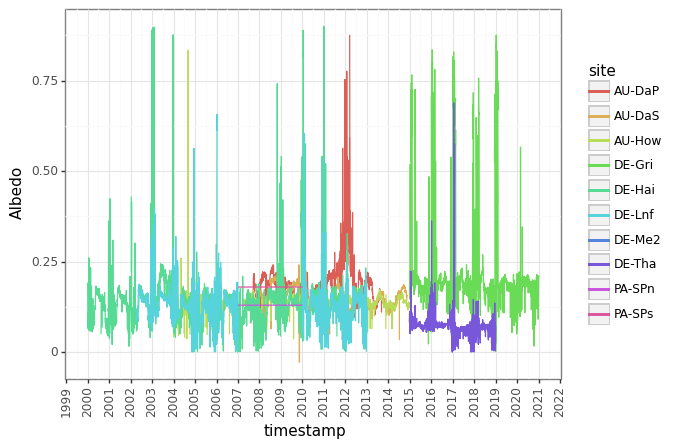

<ggplot: (87831435972)>

In [20]:
plt = ggplot(daily_albedo)
plt = plt + geom_line(aes(x = 'timestamp', y='albedo', colour='site'))
plt = plt + labs(y = 'Albedo', parse=True)
plt = plt + scale_x_datetime(breaks = date_breaks('1 years'), labels = date_format('%Y'))
plt = plt + theme_bw()
plt = plt + theme(axis_text_x = element_text(rotation=90, hjust=0.5))
plt

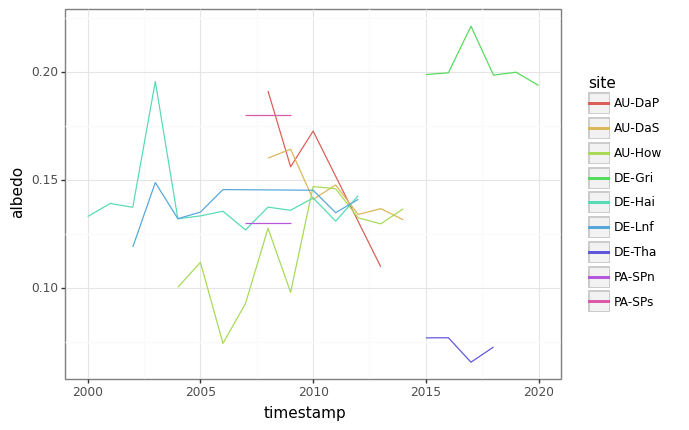

<ggplot: (87831435981)>

In [21]:
temp = yearly_all.copy()
temp['timestamp'] = pd.to_datetime(temp['year'], format = '%Y')

plt = ggplot(temp)
plt = plt + geom_line(aes(x = 'timestamp', y='albedo', colour='site'))
plt = plt + scale_x_datetime(labels=date_format('%Y'))
plt = plt + theme_bw()
plt